<a target="_blank" 
  href="https://colab.research.google.com/github/sk-classroom/word-embedding/blob/main/assignment/assignment.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Assignment

In this assignment, we will create a word embedding using the tf-idf matrix and the word2vec model from the text of Les Misérables.

Complete the following tasks and upload your notebook to your GitHub repository.

1. Fill in the blank functions, marked by, "\#TODO", in the notebook
2. Update this notebook by using `git add`, `git commit`, and then `git push`.
3. The notebook will be automatically graded, and your score will be shown on GitHub. See [how to check the results on GitHub](https://docs.github.com/en/education/manage-coursework-with-github-classroom/learn-with-github-classroom/view-autograding-results)

Dont's:
- Do not import any libraries except for the ones that are already imported. The grading script will not work if you import additional libraries.
- Do not change the name of the functions. The grading script will not work if you change the name of the functions.
- DO not remove the cells with tag "gradable". If you happen to remove the cells with tag "gradable", recreate the cell and add the tag "gradable" to the cell.
- Do not import any libraries that are not listed in the first cell. The grading script will not work if you import additional libraries.

Do's:
- Make the code clearn and easy to understand. Consider using linters & formatters such as `black`. [Youtube: Linters and fixers: never worry about code formatting again (Vim + Ale + Flake8 & Black for Python) by Yong-Yeol Ahn](https://www.youtube.com/watch?v=4FKPySR6HLk)
- You can add additional cells as you like. If you want to include the additional cells in the grading, you need to add the tag "gradable" to the cell. Otherwise, your additional cells will be stripped out when grading. 

In [184]:
# For Colab users, uncomment the following line to intall the libraries.
# !pip install spacy requests numpy pandas scipy umap-learn scikit-learn

# If this is the first time using spacy (a library for natural language processing), uncomment and run the following cell to download the English model.
# !python -m spacy downl# For Colab users, uncomment the following line to intall the libraries.
# !pip install spacy requests numpy pandas scipy umap-learn scikit-learn

# If this is the first time using spacy (a library for natural language processing), uncomment and run the following cell to download the English model.
# !python -m spacy download en_core_web_smoad en_core_web_sm

In [18]:
# You can use the following libraries. Note that other libraries (and the functions from the libraries not listed here) are not allowed, and grading will fail if you use them.
import requests
import numpy as np
import pandas as pd
from scipy import sparse
import umap
from sklearn.decomposition import PCA
import spacy
from tqdm.auto import tqdm
import gensim
import matplotlib.pyplot as plt
import seaborn as sns

# For visualization
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.io import push_notebook
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, HoverTool
import seaborn as sns


nlp = spacy.load("en_core_web_sm")

# Data preparation

Let us first download the text of Les Misérables from Project Gutenberg

In [58]:
import requests

# Download Les Misérables text from Project Gutenberg
url = "https://www.gutenberg.org/cache/epub/135/pg135.txt"
response = requests.get(url)
text = response.text


  0%|          | 0/367 [00:00<?, ?it/s]

Let us then clean the text by lemmatizing the words, removing stop words, and converting to lowercase.

In [ ]:

# Remove the header and footer
text = 'CHAPTER I—M. MYRIEL' + text.split('CHAPTER I—M. MYRIEL')[-1].split('*** END OF THIS PROJECT GUTENBERG EBOOK LES MISÉRABLES ***')[0]

# Split text into chapters and process each chapter
chapters = text.split('CHAPTER')  # Split by chapter, ignore text before first chapter

docs = []
for chapter in tqdm(chapters):
    nlp.max_length = len(chapter) + 100
    doc = nlp(chapter)

    # Clean the text:
    # 1. Remove stop words
    # 2. Remove punctuation
    # 3. Lemmatize words
    # 4. Convert to lowercase
    for sent in doc.sents:
        cleaned_tokens = [token.lemma_.lower() for token in sent
                         if not token.is_stop
                         and not token.is_punct
                         and not token.is_space]

        if len(cleaned_tokens) == 0:
            continue

        sent = ' '.join(cleaned_tokens)

        docs.append(sent)

The `docs` is a list of strings, each string is a sentence. For example, the 110th sentence is:

In [112]:
print(docs[450])

mademoiselle baptistine ambition able purchase set drawing room furniture yellow utrecht velvet stamp rose pattern mahogany swan neck style sofa


Notice that the sentence does not look natural due to the clearning process, which is expected. We will use the clearned sentences (`docs`) for the rest of the assignment to generate the character embeddings. 

## Statistics of the data

A common situation in text analysis is heterogeneity in the length of the documents. Let us first check the distribution of the document length to confirm the heterogeneity.

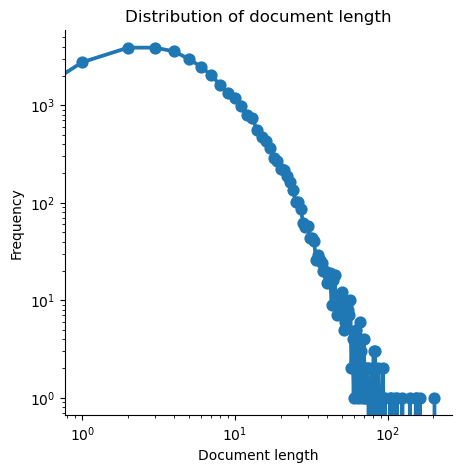

In [60]:
# Distribution of document length
doc_lengths = [len(doc.split()) for doc in docs]

doc_length_count = np.bincount(doc_lengths)

fig, ax = plt.subplots(figsize=(5, 5))

sns.pointplot(x=np.arange(len(doc_length_count)), y=doc_length_count, ax=ax)

ax.set_title("Distribution of document length")
ax.set_xlabel("Document length")
ax.set_ylabel("Frequency")
ax.set_yscale('log')
ax.set_xscale('log')

sns.despine()
plt.show()

Observe that the document length is highly skewed with a long tail. Some documents are very short consiting of only a few words, while others are very long, containing more than 100 words!

Another heterogeneity is the frequency of the words. While spacy removes the stop words that appear frequently but are not informative such as "the", "is", "in", etc., some words are still very frequent. Let us check the frequency of the words.

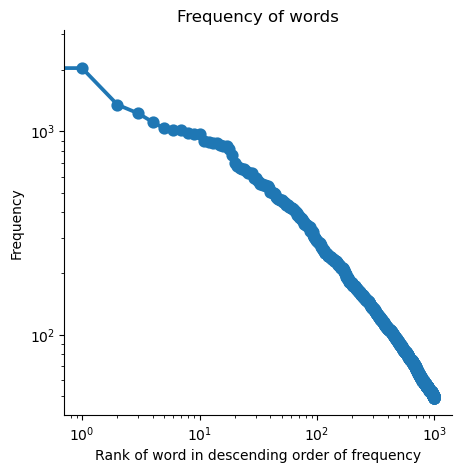

In [61]:
# Frequency of words
from collections import Counter
words = ' '.join(docs).split()
word_freq = Counter(words)

# Get all words that appear more than 10 times
df_word_freq = pd.DataFrame(word_freq.items(), columns=['word', 'freq'])
df_word_freq = df_word_freq[df_word_freq['freq'] > 10]
df_word_freq = df_word_freq.sort_values(by='freq', ascending=False)

fig, ax = plt.subplots(figsize=(5, 5))
sns.pointplot(x=np.arange(1000), y='freq', data=df_word_freq.head(1000), ax=ax)
ax.set_title("Frequency of words")
ax.set_xlabel("Rank of word in descending order of frequency")
ax.set_ylabel("Frequency")
ax.set_yscale('log')
ax.set_xscale('log')
sns.despine()


This is also highly skewed with a long tail. In fact, it is known that the frequency of words robsutly follow a power law distribution. See the lecture notes for more details. 

## Assignment

### Task 1: Calculate the tf-idf matrix

The tf-idf matrix is a matrix that represents the importance of each word in each document. The tf-idf matrix is calculated by first calculating the term frequency (tf) matrix, then calculating the inverse document frequency (idf) matrix, and then multiplying the two matrices.
Your task is to implement the function `calculate_tf_idf_matrix` to calculate the tf-idf matrix. This function should return the tf-idf matrix and the mapping from word to index.
1. Input: `docs`: list of strings, each string is a document.
2. Output: `tfidf_matrix`: 2D numpy array, the tf-idf matrix of size (n_words, n_docs).
3. Output: `word_to_idx`: dictionary, the mapping from word to index with keys as words and values as indices of the tf-idf matrix.

Note: 
- You should split each document into words by space using the `split()` method, e.g., docs[0].split() will return a list of words in the first document.
- The values of the word_to_idx should be integers starting from 0. The index corresponds to the row index of the tf-idf matrix. For example, if the word "javert" is the 10th word in the tf-idf matrix, the index of "javert" in the word_to_idx should be 10.
- The process may take a long time if you naively use it using the for loops. Consider this as the opportunity to learn convenient numpy operations such as `np.einsum` and `np.sum` to speed up the computation. 


In [113]:
# TODO: Implement this function
def calculate_tf_idf_matrix(docs):
    """Generate tf-idf matrix from documents.
    Args:
        documents: list of strings, each string is a document.
    Returns:
        tfidf_matrix: 2D numpy array, the tf-idf matrix.
        word_to_idx: dictionary, the mapping from word to index.
    """
    pass

In [114]:
def calculate_tf_idf_matrix(docs):
    """Generate tf-idf matrix from documents.
    Args:
        documents: list of strings, each string is a document.
    Returns:
        tfidf_matrix: 2D numpy array, the tf-idf matrix.
        word_to_idx: dictionary, the mapping from word to index.
    """

    vocab = set(" ".join(docs).split())
    word_to_idx = dict(zip(vocab, np.arange(len(vocab))))
    n_docs = len(docs)
    n_terms = len(vocab)
    tf_matrix = np.zeros((n_terms, n_docs))

    for doc_id, doc in tqdm(enumerate(docs), total=len(docs)):
        word_ids_in_doc = [word_to_idx[word] for word in doc.split()]
        tf_matrix[:, doc_id] = np.bincount(word_ids_in_doc, minlength=n_terms)

    # Normalize the term frequencies by the number of words in each document
    tf_matrix = np.einsum('ij,j->ij', tf_matrix, 1 / np.maximum(1, np.sum(tf_matrix, axis=0)))

    # Calculate IDF for each term
    # let's use tf_matrix to calculate the document frequency
    doc_freq = np.sum(tf_matrix > 0, axis=1).reshape(-1)
    idf = np.log(n_docs / doc_freq)

    # Calculate TF-IDF matrix
    tfidf_matrix = np.einsum('i,ij->ij', idf, tf_matrix)
    return tfidf_matrix, word_to_idx

In [115]:
tfidf_matrix, word_to_idx = calculate_tf_idf_matrix(docs)

  0%|          | 0/32705 [00:00<?, ?it/s]

In [117]:
# If you could compute the tf-idf matrix correctly, the following test should pass.
data = np.load("tfidf_matrix_signature.npz")
u, s, vh = data["u"], data["s"], data["vh"]
assert np.mean(np.abs(np.diag(u.T @ tfidf_matrix @ vh.T)-s)) < 1e-2, "The tfidf matrix is not correctly computed."


## Task 2: Embed the characters

The characters in Les Misérables are grouped into several categories. We will use the tf-idf matrix to embed the characters into a 2D space.

Implement the function `embed_tfidf_matrix` to embed the words into a 32 dimensional space using PCA.
The matrix will take the tf-idf vectors of the words as input and return the embedded vectors.
The embedding will be generated by using the PCA. 
The input and output are as follows:
1. Input: `tfidf_matrix`: 2D numpy array, the tf-idf vectors of the words, of size (n_words, n_docs).
2. Output: `emb`: 2D numpy array, the embedded vectors of the characters, of size (n_characters, 32).

Note: 
- You can use the `PCA` class from `sklearn.decomposition` to perform the PCA.
- The number of components should be 32.


In [120]:
# TODO: Implement this function
def embedding_characters(character_tfidx_matrix):
    """
    Embed characters into 32 dimensional space using PCA

    Args:
        character_tfidx_matrix: 2D numpy array, the tf-idf matrix for characters, of size (n_characters, n_docs)
    Returns:
        embedded_characters: 2D numpy array of size (n_characters, 32)
    """
    pass

In [121]:
# TODO: Implement this function
def embedding_characters(character_tfidx_matrix):
    """
    Embed characters into 32 dimensional space using PCA

    Args:
        character_tfidx_matrix: 2D numpy array, the tf-idf matrix for characters, of size (n_characters, n_docs)
    Returns:
        embedded_characters: 2D numpy array of size (n_characters, 32)
    """
    pca = PCA(n_components=32)
    embedded_characters = pca.fit_transform(character_tfidx_matrix)
    return embedded_characters

In [138]:
emb = embedding_characters(tfidf_matrix)

In [143]:
# If you could compute the embedding correctly, the following test should pass.
assert emb.shape[1] == 32, "The embedding dimension is not 32"
assert emb.shape[0] == len(word_to_idx), "The number of words is not correct"
assert np.mean(np.linalg.norm(emb, axis=0)) > 0.99, "The embedding is not normalized"
assert np.allclose(np.mean(emb, axis=0), np.zeros(32), atol=1e-2), "The embedding is not centered"

## Visualization 

Let us visualize the character embedding using UMAP.



In [240]:
df_characters = pd.DataFrame([
    ['myriel', '', 'male'],
    ['napoleon', '', 'male'],
    ['cravatte', '', 'male'],
    ['labarre', '', 'male'],
    ['jean', 'valjean_household', 'male'],
    ['marguerite', '', 'female'],
    ['isabeau', '', 'female'],
    ['gervais', '', 'male'],
    ['listolier', 'young_paris_circle', 'male'],
    ['fameuil', 'young_paris_circle', 'male'],
    ['favourite', 'young_paris_circle', 'female'],
    ['dahlia', 'young_paris_circle', 'female'],
    ['fantine', 'young_paris_circle', 'female'],
    ['cosette', 'valjean_household', 'female'],
    ['javert', 'trial_characters', 'male'],
    ['fauchelevent', 'valjean_household', 'male'],
    ['bamatabois', '', 'male'],
    ['simplice', 'trial_characters', 'female'],
    ['scaufflaire', 'trial_characters', 'male'],
    ['judge', 'trial_characters', 'male'],
    ['champmathieu', 'trial_characters', 'male'],
    ['brevet', 'trial_characters', 'male'],
    ['chenildieu', 'trial_characters', 'male'],
    ['cochepaille', 'trial_characters', 'male'],
    ['pontmercy', '', 'male'],
    ['boulatruelle', '', 'male'],
    ['gribier', '', 'male'],
    ['jondrette', '', 'male'],
    ['gavroche', '', 'male'],
    ['gillenormand', '', 'male'],
    ['magnon', '', 'female'],
    ['marius', '', 'male'],
    ['mabeuf', '', 'male'],
    ['enjolras', 'revolutionary_core', 'male'],
    ['combeferre', 'revolutionary_core', 'male'],
    ['prouvaire', 'revolutionary_core', 'male'],
    ['feuilly', 'revolutionary_core', 'male'],
    ['courfeyrac', 'revolutionary_core', 'male'],
    ['bahorel', 'revolutionary_core', 'male'],
    ['bossuet', 'revolutionary_core', 'male'],
    ['joly', 'revolutionary_core', 'male'],
    ['grantaire', 'revolutionary_core', 'male'],
    ['gueulemer', 'thenardier_gang', 'male'],
    ['babet', 'thenardier_gang', 'male'],
    ['claquesous', 'thenardier_gang', 'male'],
    ['montparnasse', 'thenardier_gang', 'male'],
    ['toussaint', 'valjean_household', 'female'],
    ['brujon', 'thenardier_gang', 'male']
], columns=['character', 'group', 'gender'])

Let us then retrieve the tf-idf vectors for the characters.

In [241]:
les_miserables_characters = df_characters['character'].tolist()

emb_characters  = np.zeros((len(les_miserables_characters), emb.shape[1]))
for i, character in enumerate(les_miserables_characters):
    emb_characters[i, :] = emb[word_to_idx[character], :]

In [242]:
# If you could compute the embedding correctly, the following test should pass.
# The similarity between the characters within the groups should be higher than the similarity between the characters across the groups.
# The similarity is measured by the cosine similarity.
focal_groups = ['revolutionary_core', 'young_paris_circle', "thenardier_gang"]
n_emb_characters = np.einsum('ij,i->ij', emb_characters, 1.0 / np.linalg.norm(emb_characters, axis=1))
group_centroids = np.array([np.mean(n_emb_characters[df_characters['group'] == group], axis=0) for group in focal_groups])
group_similarieis = group_centroids @ group_centroids.T
within_group_similarities = np.mean(np.diag(group_similarieis))
between_group_similarities = np.sum(group_similarieis - np.diag(group_similarieis)) / (len(focal_groups) * (len(focal_groups) - 1))

assert within_group_similarities > between_group_similarities, "The groups are not well separated"

Now, let's explore the emebdding space using the `gensim` library.

In [243]:
# Create a KeyedVectors object from the embedding matrix that allows us to use the gensim's APIs to explore the embedding space.
kv = gensim.models.KeyedVectors(emb.shape[1])
kv.add_vectors([word for word in word_to_idx.keys()], emb) # This is how you add vectors to the KeyedVectors object

Let us first see the most similar words to "javert"

In [244]:
kv.most_similar('jean')

[('valjean', 0.9790983200073242),
 ('ingenuously', 0.7567152976989746),
 ('review', 0.756148636341095),
 ('recapture', 0.7431069612503052),
 ('dumb', 0.7429089546203613),
 ('testimony', 0.740816593170166),
 ('curtsey', 0.7378146648406982),
 ('sadly', 0.7303010821342468),
 ('revenge', 0.7278681993484497),
 ('apprehensions', 0.726777970790863)]

You might observe that some characters are very similar to each other. For example, "valjean" and "jean" are very similar which reflects the fact that Jean Valjean is literally "Jean" - they're the same character!
Additionally, you might observe that "mathieu" and "valjean" are also very similar. This is because "mathieu" is the character who is mistaken for "valjean" in the story.

Finally, let us visualize the embedding using UMAP.

In [249]:
output_notebook()

# Create a list of colors and groups for each character

def visualize_characters(embedded_characters, group_name = "group"):
    """
    Visualize the characters using UMAP
    """
    reducer = umap.UMAP(n_components=2, metric='cosine', n_neighbors=15, min_dist=0.05, random_state=42)
    xy = reducer.fit_transform(embedded_characters)
    colors = []
    groups = []
    palette = sns.color_palette().as_hex()
    group_colors = {group: palette[i] for i, group in enumerate(df_characters[group_name].unique())}
    group_colors[""] = "#fafafa"
    for idx, row in df_characters.iterrows():
        color = group_colors[row[group_name]]
        colors.append(color)
        groups.append(row[group_name])

    # Prepare data for Bokeh
    source = ColumnDataSource(data=dict(
        x=xy[:, 0],
        y=xy[:, 1],
        text_x=xy[:, 0],
        text_y=xy[:, 1],
        character=les_miserables_characters,
        colors=colors,
        group=groups
    ))

    p = figure(title="Les Misérables Character embedding", x_axis_label="X", y_axis_label="Y",
              width=800, height=600)

    # Add hover tool
    hover = HoverTool(tooltips=[
        ('Character', '@character'),
        ('Group', '@group')
    ])
    p.add_tools(hover)

    # Plot points with colors by group
    p.scatter('x', 'y', source=source, fill_color='colors', line_color="black", size=15)

    # Add labels to the points
    p.text(x='text_x', y='text_y', text='character', source=source,
           text_font_size="8pt", text_baseline="middle", text_align="center")

    show(p)
visualize_characters(emb_characters)

Loading BokehJS ...

/Users/skojaku-admin/miniforge3/envs/advnetsci/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


# Task 3: 

Now, let us use word2vec to generate the embeddings. You can use the `gensim` library to generate the embeddings.

- The input is the same as the previous task.
- The output is the embedding matrix and the mapping from word to index, as is the case in the previous task.
- Use `gensim.models.Word2Vec` to generate the embeddings.
- When generating the word2vec embeddiing, make sure to train it using the skip-gram model with negative sampling by setting `sg = 1` and `hs = 0`.
- Set min_count to 1, epochs to 10, window to 30 and vector_size to 32. Read the documentation of `gensim.models.Word2Vec` to understand the parameters for more details.

In [176]:
# TODO: Implement this function
def generate_word2vec_embeddings(docs):
    """
    Generate word2vec embeddings from documents.
    """

    # This is the code to generate the sequences of words from the documents, which will be fed into the word2vec model.
    sequences = [doc.split() for doc in docs]

    # Your code here ----
    model = ...

    # ----------------------------

    # This is the code to generate the embeddings from the word2vec model
    emb = np.zeros((len(model.wv.index_to_key), 32))
    word_to_idx = dict(zip(model.wv.index_to_key, np.arange(len(model.wv.index_to_key))))
    for i, word in enumerate(model.wv.index_to_key):
        emb[i, :] = model.wv[word]
    return emb, word_to_idx

In [217]:
# TODO: Implement this function
def generate_word2vec_embeddings(docs):
    """
    Generate word2vec embeddings from documents.
    """
    sequences = [doc.split() for doc in docs]
    model = gensim.models.Word2Vec(sequences, vector_size=32, window=30, min_count=1, workers=4, epochs = 10, sg = 1, hs = 0)

    emb = np.zeros((len(model.wv.index_to_key), 32))
    word_to_idx = dict(zip(model.wv.index_to_key, np.arange(len(model.wv.index_to_key))))
    for i, word in enumerate(model.wv.index_to_key):
        emb[i, :] = model.wv[word]
    return emb, word_to_idx

Let us now generate the word2vec embeddings.

In [209]:
emb, word_to_idx = generate_word2vec_embeddings(docs)

In [211]:
assert emb.shape[1] == 32, "The embedding dimension is not 32"
assert emb.shape[0] == len(word_to_idx), "The number of words is not correct"

les_miserables_characters = df_characters['character'].tolist()
emb_characters  = np.zeros((len(les_miserables_characters), emb.shape[1]))
for i, character in enumerate(les_miserables_characters):
    emb_characters[i, :] = emb[word_to_idx[character], :]

focal_groups = ['revolutionary_core', 'young_paris_circle', "thenardier_gang"]
n_emb_characters = np.einsum('ij,i->ij', emb_characters, 1.0 / np.linalg.norm(emb_characters, axis=1))
group_centroids = np.array([np.mean(n_emb_characters[df_characters['group'] == group], axis=0) for group in focal_groups])
group_similarieis = group_centroids @ group_centroids.T
within_group_similarities = np.mean(np.diag(group_similarieis))
between_group_similarities = np.sum(group_similarieis - np.diag(group_similarieis)) / (len(focal_groups) * (len(focal_groups) - 1))

assert within_group_similarities > between_group_similarities, "The groups are not well separated"

Let's visualize the word2vec embeddings. If successful, the groups should be well separated.

In [213]:
output_notebook()
visualize_characters(emb_characters)

Loading BokehJS ...

/Users/skojaku-admin/miniforge3/envs/advnetsci/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Finally, confirm the most similar words to "jean" are "javert" and "cosette".

In [206]:
kv = gensim.models.KeyedVectors(emb.shape[1])
kv.add_vectors([word for word in word_to_idx.keys()], emb)
kv.most_similar('jean')

[('valjean', 0.9762178659439087),
 ('ingenuously', 0.7919862866401672),
 ('difficulty', 0.7879906892776489),
 ('annoy', 0.7828221321105957),
 ('review', 0.766194224357605),
 ('recapture', 0.7621065974235535),
 ('javert', 0.7615678310394287),
 ('gribier', 0.7602510452270508),
 ('attentively', 0.758249044418335),
 ('inclination', 0.7565301060676575)]

In [216]:
kv.most_similar('javert')

[('apprehend', 0.82332444190979),
 ('spy', 0.8103542923927307),
 ('inspector', 0.8095024228096008),
 ('valjean', 0.802627444267273),
 ('annoy', 0.792702853679657),
 ('recognize', 0.7881721258163452),
 ('chenildieu', 0.78486168384552),
 ('cochepaille', 0.7823243141174316),
 ('relinquish', 0.779717743396759),
 ('brevet', 0.7750605344772339)]

In [214]:
kv.most_similar('cosette')

[('marius', 0.8599963188171387),
 ('inseparable', 0.851218581199646),
 ('unspeakably', 0.8432673215866089),
 ('indefinitely', 0.8350207805633545),
 ('plutarque', 0.8340430855751038),
 ('thine', 0.8261262774467468),
 ('desk', 0.8260175585746765),
 ('persuade', 0.823432207107544),
 ('consciousness', 0.8173910975456238),
 ('avow', 0.813552975654602)]

## Task 4: Semaxis analysis 

Semaxis is a method to analyze the semantic space ([reference](https://aclanthology.org/P18-1228/)). Let us calculate the semaxis between "justice" and "mercy" and project the characters onto the semaxis. 

In [264]:
def get_semaxis(emb, kv, pos_word, neg_word):
    """
    Calculate the semantic axis between two words.

    Args:
        emb: 2D numpy array, the embedding matrix of size (n_words, n_dimensions).
        pos_word: str, the positive word.
        neg_word: str, the negative word.
        kv: gensim.models.KeyedVectors, the word2vec model.
    Returns:
        semaxis_scores: 1D numpy array, the scores of the characters on the semaxis, of size (n_characters,).
    """

    pos_vec = kv.get_vector(pos_word).copy()
    neg_vec = kv.get_vector(neg_word).copy()

    # Your code here ----

    # -------------------

    return

In [272]:
def get_semaxis(emb, kv, pos_word, neg_word):
    """
    Calculate the semantic axis between two words.

    Args:
        emb: 2D numpy array, the embedding matrix of size (n_words, n_dimensions).
        pos_word: str, the positive word.
        neg_word: str, the negative word.
        kv: gensim.models.KeyedVectors, the word2vec model.
    Returns:
        semaxis_scores: 1D numpy array, the scores of the characters on the semaxis, of size (n_characters,).
    """

    pos_vec = kv.get_vector(pos_word).copy()
    neg_vec = kv.get_vector(neg_word).copy()

    # Your code here ----
    semaxis_vec = pos_vec - neg_vec
    semaxis_vec /= np.linalg.norm(semaxis_vec)

    nemb = emb / np.linalg.norm(emb, axis=1, keepdims=True)

    semaxis_scores = nemb @ semaxis_vec
    # -------------------

    return semaxis_scores

In [291]:
semaxis_scores = get_semaxis(emb, kv, 'justice', 'mercy')

In [292]:
# If the function is implemented correctly, the following test should pass.
for i in range(10):
    pos_word  = np.random.choice(kv.index_to_key)
    neg_word = np.random.choice(kv.index_to_key)
    pos_vec = kv.get_vector(pos_word).copy()
    neg_vec = kv.get_vector(neg_word).copy()
    _semaxis_scores = get_semaxis(np.array([[pos_vec - neg_vec],[neg_vec - pos_vec]]).reshape(2,-1), kv, pos_word, neg_word)

    assert np.allclose(_semaxis_scores[0], 1), "The semaxis scores are not correctly computed"
    assert np.allclose(_semaxis_scores[1], -1), "The semaxis scores are not correctly computed"

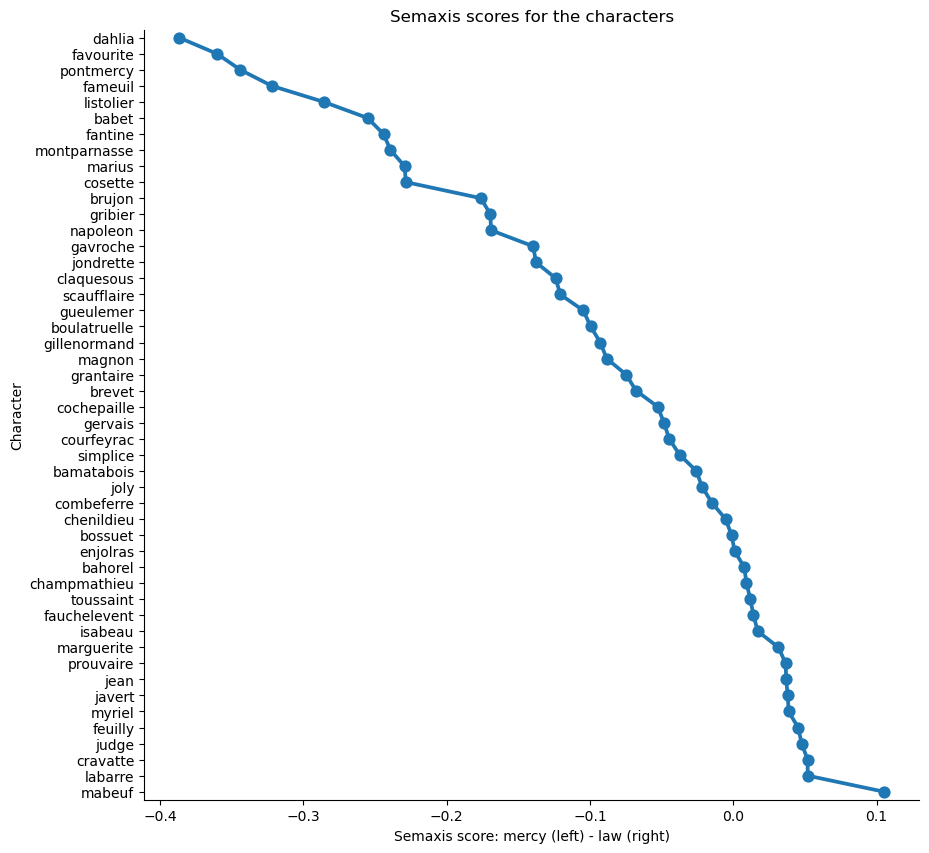

In [293]:

#semaxis_scores = get_semaxis(emb, 'justice', 'mercy')
semaxis_scores_characters = np.array([semaxis_scores[word_to_idx[character]] for character in les_miserables_characters])

# Plot the scores for the characters
fix, ax = plt.subplots(figsize=(10, 10))
order = np.argsort(semaxis_scores_characters)
ax = sns.pointplot(y = [les_miserables_characters[i] for i in order], x = semaxis_scores_characters[order], ax = ax)
ax.set_title("Semaxis scores for the characters")
ax.set_xlabel("Semaxis score: mercy (left) - law (right)")
ax.set_ylabel("Character")
sns.despine()


Let's also see the gender axis. Les Misérables is a male-dominated story. But there are some female characters as well. Let's see how the characters are distributed on the gender axis.

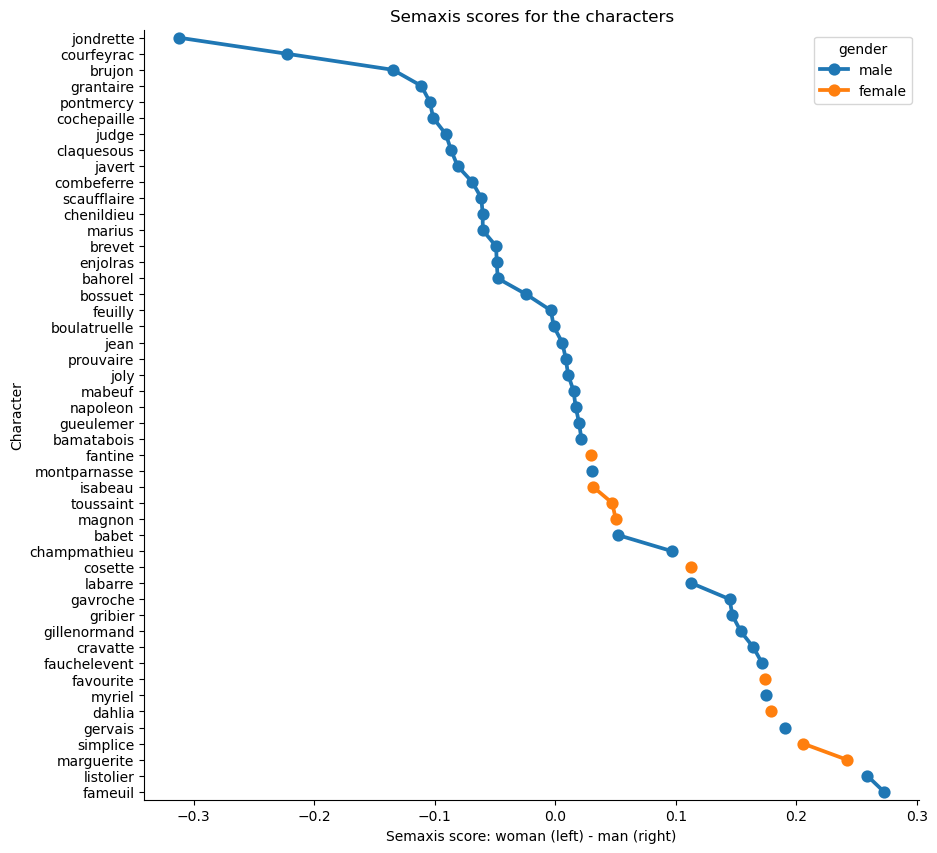

In [298]:
# This is the semaxis score for the gender axis.
semaxis_scores = get_semaxis(emb, kv, 'man', 'woman')

semaxis_scores_characters = np.array([semaxis_scores[word_to_idx[character]] for character in les_miserables_characters])

# Plot the scores for the characters
fix, ax = plt.subplots(figsize=(10, 10))
order = np.argsort(semaxis_scores_characters)
ax = sns.pointplot(y = [les_miserables_characters[i] for i in order], x = semaxis_scores_characters[order], hue = df_characters['gender'][order], ax = ax)
ax.set_title("Semaxis scores for the characters")
ax.set_xlabel("Semaxis score: woman (left) - man (right)")
ax.set_ylabel("Character")
sns.despine()

Let's see the gender bias in occupations.



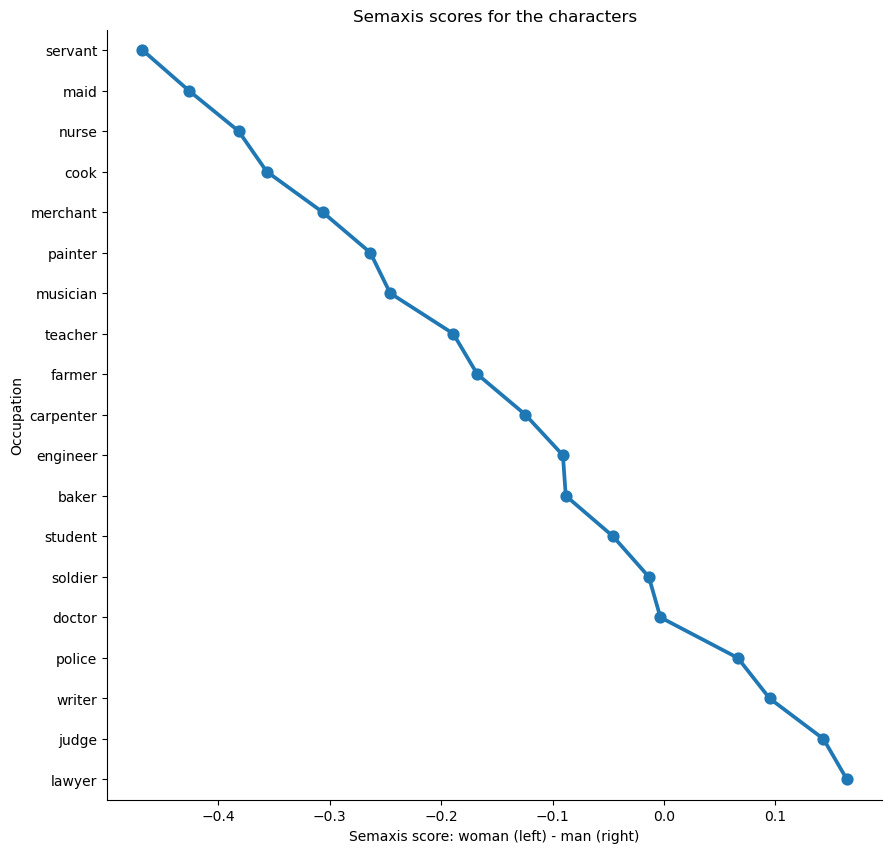

In [308]:
occupations = [
    'lawyer',
    'doctor',
    'teacher',
    'nurse',
    'cook',
    'maid',
    'servant',
    'farmer',
    "judge",
    "police",
    "engineer",
    "writer",
    "musician",
    "merchant",
    "baker",
    "carpenter",
    "painter",
    "soldier",
    "student"
]

semaxis_scores = get_semaxis(emb, kv, 'man', 'woman')
semaxis_scores_occupations = np.array([semaxis_scores[word_to_idx[occupation]] for occupation in occupations])

# Plot the scores for the characters
fix, ax = plt.subplots(figsize=(10, 10))
order = np.argsort(semaxis_scores_occupations)
ax = sns.pointplot(y = [occupations[i] for i in order], x = semaxis_scores_occupations[order], ax = ax)
ax.set_title("Semaxis scores for the characters")
ax.set_xlabel("Semaxis score: woman (left) - man (right)")
ax.set_ylabel("Occupation")
sns.despine()

Some occupations are more male-dominated than others. For example, "judge", "lawyer", "writer" and "police" are more male-dominated than others, despite the fact female characters may have these occupations.
While such a gender bias is not explicitly present in the story, the word embedding captures implicit gender bias from the text.  